# Incorporating lightcurves

The goal of this notebook is to demonstrate the use of lightcurves within `sorcha`

In [1]:
import pandas as pd
import numpy as np
import astropy.units as u
from astroquery.jplhorizons import Horizons
from sorcha_addons.lightcurve.sinusoidal.sinusoidal_lightcurve import SinusoidalLightCurve
from sorcha.modules.PPCalculateApparentMagnitudeInFilter import PPCalculateApparentMagnitudeInFilter
import matplotlib.pyplot as plt

This notebook will not use a realistic set of observations (as in the `demo_ApparentMagnitudeValidation` notebook), but rather create a toy scenario with a simple to understand and interpret set of results. The general structure of the notebook will be the same.

We will create a dataframe for observations in a similar structure as in the `demo_ApparentMagnitudeValidation` notebook:

In [31]:
observations_df = pd.DataFrame({'FieldMJD_TAI': np.linspace(0, 100, 1001), #time of observation - note these values are bogus, we only care about the Delta t for this demo
                                'H_filter': 10 * np.ones(1001),
                                'GS': 0.15 * np.ones(1001),
                                'G1': 0.62 * np.ones(1001),
                                'G2': 0.14 * np.ones(1001),
                                'G12': 0.68 * np.ones(1001),
                                'S': 0.04 * np.ones(1001),
                                'AstRange(km)': 1.495978707e8 * np.ones(1001), #1 au 
                                'Ast-Sun(km)': 1.495978707e8 * np.ones(1001), #1 au
                                'Sun-Ast-Obs(deg)': np.linspace(0, 10, 1001)}) #some phase angle variation so we can see the phase curve on top of the lightcurve

In [3]:
observations_df

,FieldMJD_TAI,H_filter,GS,G1,G2,G12,S,AstRange(km),Ast-Sun(km),Sun-Ast-Obs(deg)
0,0.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.0
1,1.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.1
2,2.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.2
3,3.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.3
4,4.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.4
...,...,...,...,...,...,...,...,...,...,...
96,96.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.6
97,97.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.7
98,98.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.8
99,99.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.9


Now we calculate the magnitude using the various models in PPCalculateApparentMagnitudeInFilter.

In [32]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG', 'r', 'HG_mag')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG12', 'r', 'HG12_mag')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG1G2', 'r', 'HG1G2_mag')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'linear', 'r', 'linear_mag')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'none', 'r', 'Simple_mag')

In [5]:
observations_df

,FieldMJD_TAI,H_filter,GS,G1,G2,G12,S,AstRange(km),Ast-Sun(km),Sun-Ast-Obs(deg),HG_mag,HG12_mag,HG1G2_mag,linear_mag,Simple_mag
0,0.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.0,10.000000,10.000000,10.000000,10.000,10.0
1,1.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.1,10.013734,10.010097,10.009755,10.004,10.0
2,2.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.2,10.027121,10.030427,10.029111,10.008,10.0
3,3.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.3,10.040177,10.054225,10.051704,10.012,10.0
4,4.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,0.4,10.052916,10.075571,10.071983,10.016,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.6,10.643044,10.613831,10.609068,10.384,10.0
97,97.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.7,10.646919,10.617955,10.613339,10.388,10.0
98,98.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.8,10.650777,10.622070,10.617601,10.392,10.0
99,99.0,10.0,0.15,0.62,0.14,0.68,0.04,149597870.7,149597870.7,9.9,10.654619,10.626176,10.621855,10.396,10.0


Now we can plot the magnitudes and compare them.

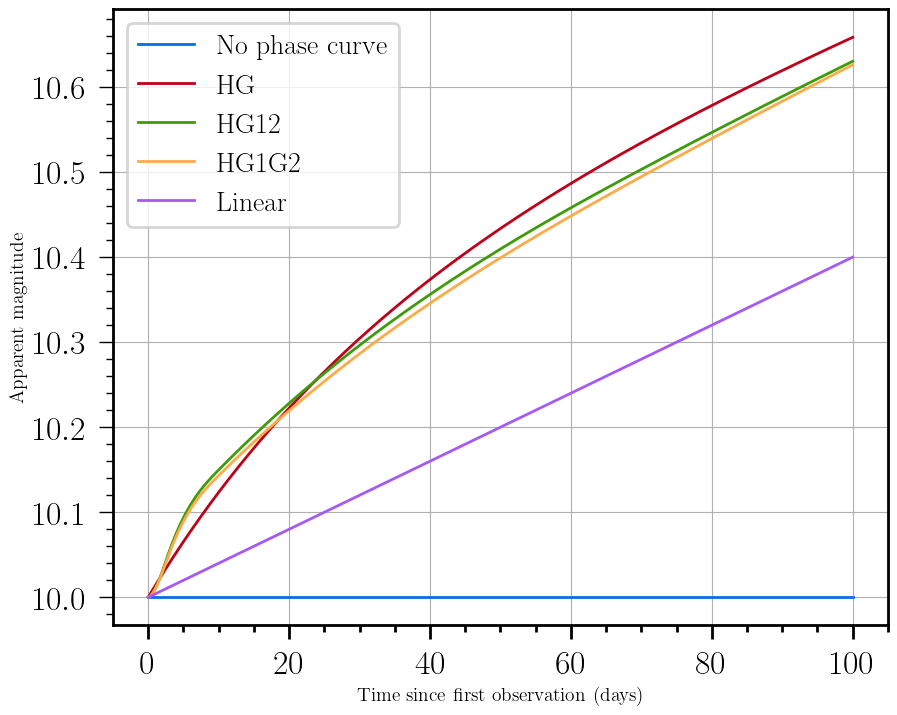

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(observations_df["FieldMJD_TAI"], observations_df["Simple_mag"], linestyle="-", label="No phase curve")
ax.plot(observations_df["FieldMJD_TAI"], observations_df["HG_mag"], label="HG")
ax.plot(observations_df["FieldMJD_TAI"], observations_df["HG12_mag"], label="HG12")
ax.plot(observations_df["FieldMJD_TAI"], observations_df["HG1G2_mag"], label="HG1G2")
ax.plot(observations_df["FieldMJD_TAI"], observations_df["linear_mag"], label="Linear")

ax.legend()
ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
plt.grid()
plt.show()

The effect of the lightcurve is to add an extra term to the apparent magnitude, that, in principle, can be a function of the characteristics of the observations, such as time of observation, phase angle or topocentric and heliocentric distances. The entire `observational_df` dataframe is exposed to the lightcurve, so any dependencies can be added. 

Let's use the basic sinusoidal lightcurve from `sorcha_addons`. We need the following columns in our dataframe:

    * ``LCA`` - lightcurve amplitude [magnitudes].
    * ``Period`` - period of the sinusoidal oscillation [days]. Should be a positive value.
    * ``Time0`` - phase for the light curve [days].

Let's create a lightcurve with a period of 20 days, phased so that the first observation is at zero variation, and with 0.5 mag peak-to-peak amplitude.

In [10]:
from sorcha.lightcurves.lightcurve_registration import LC_METHODS, update_lc_subclasses 
# LC_METHODS is the dictionary that contains all lightcurve implementations
# update_lc_subclasses adds newly defined classes to this dictionary
# this is run by default inside sorcha
update_lc_subclasses()
print(LC_METHODS)

{'identity': <class 'sorcha.lightcurves.identity_lightcurve.IdentityLightCurve'>, 'sinusoidal': <class 'sorcha_addons.lightcurve.sinusoidal.sinusoidal_lightcurve.SinusoidalLightCurve'>}


In [34]:
observations_df['LCA'] = 0.25 #note peak-to-peak is 2LCA! 
observations_df['Period'] = 20.
observations_df['Time0'] = 0.



In [35]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'none', 'r', 'LCA_mag', 'sinusoidal')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG', 'r', 'LCA_HG_mag', 'sinusoidal')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG12', 'r', 'LCA_HG12_mag', 'sinusoidal')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG1G2', 'r', 'LCA_HG1G2_mag', 'sinusoidal')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'linear', 'r', 'LCA_linear_mag', 'sinusoidal')


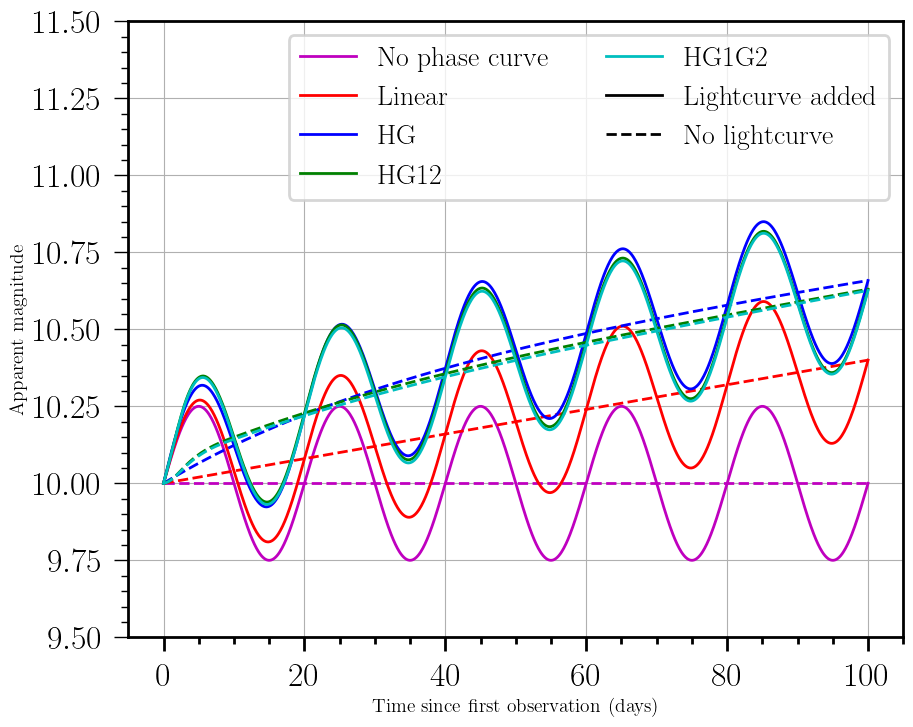

In [36]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(observations_df["FieldMJD_TAI"], observations_df["Simple_mag"], linestyle="--", label="__none__", color='m', )
ax.plot(observations_df["FieldMJD_TAI"], observations_df["LCA_mag"], linestyle="-", label="__none__", color='m')

ax.plot(observations_df["FieldMJD_TAI"], observations_df["linear_mag"], linestyle="--", label="__none__", color='r', )
ax.plot(observations_df["FieldMJD_TAI"], observations_df["LCA_linear_mag"], linestyle="-", label="__none__", color='r')


ax.plot(observations_df["FieldMJD_TAI"], observations_df["HG_mag"], linestyle="--", label="__none__", color='b', )
ax.plot(observations_df["FieldMJD_TAI"], observations_df["LCA_HG_mag"], linestyle="-", label="__none__", color='b')

ax.plot(observations_df["FieldMJD_TAI"], observations_df["HG12_mag"], linestyle="--", label="__none__", color='g', )
ax.plot(observations_df["FieldMJD_TAI"], observations_df["LCA_HG12_mag"], linestyle="-", label="__none__", color='g')

ax.plot(observations_df["FieldMJD_TAI"], observations_df["HG1G2_mag"], linestyle="--", label="__none__", color='c', )
ax.plot(observations_df["FieldMJD_TAI"], observations_df["LCA_HG1G2_mag"], linestyle="-", label="__none__", color='c')


custom_legend = [Line2D([0], [0], color='m', linestyle='-'), Line2D([0], [0], color='r', linestyle='-'),
                 Line2D([0], [0], color='b', linestyle='-'), Line2D([0], [0], color='g', linestyle='-'),
                 Line2D([0], [0], color='c', linestyle='-'), Line2D([0], [0], color='k', linestyle='-'),
                 Line2D([0], [0], color='k', linestyle='--'), ]

ax.legend(custom_legend, ['No phase curve', 'Linear', 'HG', 'HG12', 'HG1G2','Lightcurve added', 'No lightcurve'], ncol=2)
ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
ax.set_ylim(9.5, 11.5)
plt.grid()
plt.show()

### Incorporating your own lightcurve

You can also implement a custom lightcurve. To do so, you need to inherit from the `AbstractLightCurve` class inside `sorcha`. Let's implement a simple extension of this sinusoidal model, where we have two sine terms at once. The implementation will be very similar to the `SinusoidalLightCurve` class used above.

In [25]:
from sorcha.lightcurves.base_lightcurve import AbstractLightCurve

from sorcha.lightcurves.base_lightcurve import AbstractLightCurve

from typing import List
import pandas as pd
import numpy as np


class DoubleSinusoidalLightCurve(AbstractLightCurve):
    def __init__(self, required_column_names: List[str] = ["FieldMJD_TAI", "LCA", "Period1", "Period2", "Time0"]) -> None:
        super().__init__(required_column_names)

    def compute(self, df: pd.DataFrame) -> np.array:
        # Verify that the input data frame contains each of the required columns.
        self._validate_column_names(df)

        time1 = 2 * np.pi * (df["FieldMJD_TAI"] - df["Time0"]) / df["Period1"]
        time2 = 2 * np.pi * (df["FieldMJD_TAI"] - df["Time0"]) / df["Period2"]

        return df["LCA"] * np.sin(time1) * np.sin(time2)

	#this method defines the same of the class inside LC_METHODS
    @staticmethod
    def name_id() -> str:
        return "doublesinusoidal"

In [26]:
update_lc_subclasses()
print(LC_METHODS)

{'identity': <class 'sorcha.lightcurves.identity_lightcurve.IdentityLightCurve'>, 'sinusoidal': <class 'sorcha_addons.lightcurve.sinusoidal.sinusoidal_lightcurve.SinusoidalLightCurve'>, 'doublesinusoidal': <class '__main__.DoubleSinusoidalLightCurve'>}


In [49]:
# let's add the required columns that are different from the sinusoidal lightcurve
observations_df['Period1'] = 20.
observations_df['Period2'] = 4.

In [50]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'none', 'r', 'DLCA_mag', 'doublesinusoidal')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG', 'r', 'DLCA_HG_mag', 'doublesinusoidal')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG12', 'r', 'DLCA_HG12_mag', 'doublesinusoidal')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG1G2', 'r', 'DLCA_HG1G2_mag', 'doublesinusoidal')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'linear', 'r', 'DLCA_linear_mag', 'doublesinusoidal')


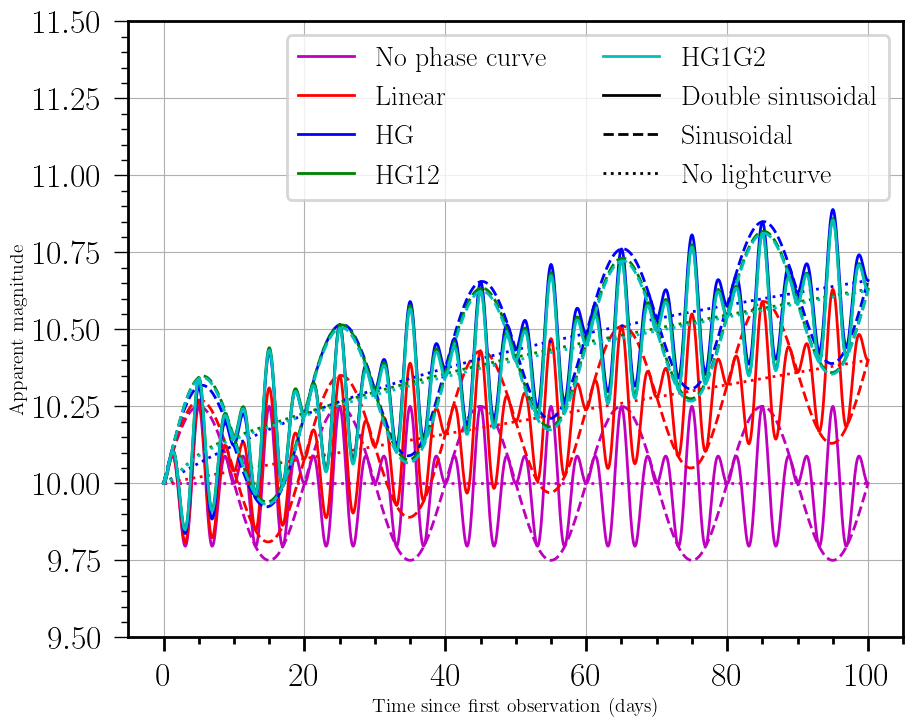

In [51]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(observations_df["FieldMJD_TAI"], observations_df["Simple_mag"], linestyle=":", label="__none__", color='m', )
ax.plot(observations_df["FieldMJD_TAI"], observations_df["LCA_mag"], linestyle="--", label="__none__", color='m')
ax.plot(observations_df["FieldMJD_TAI"], observations_df["DLCA_mag"], linestyle="-", label="__none__", color='m')


ax.plot(observations_df["FieldMJD_TAI"], observations_df["linear_mag"], linestyle=":", label="__none__", color='r', )
ax.plot(observations_df["FieldMJD_TAI"], observations_df["LCA_linear_mag"], linestyle="--", label="__none__", color='r')
ax.plot(observations_df["FieldMJD_TAI"], observations_df["DLCA_linear_mag"], linestyle="-", label="__none__", color='r')


ax.plot(observations_df["FieldMJD_TAI"], observations_df["HG_mag"], linestyle=":", label="__none__", color='b', )
ax.plot(observations_df["FieldMJD_TAI"], observations_df["LCA_HG_mag"], linestyle="--", label="__none__", color='b')
ax.plot(observations_df["FieldMJD_TAI"], observations_df["DLCA_HG_mag"], linestyle="-", label="__none__", color='b')

ax.plot(observations_df["FieldMJD_TAI"], observations_df["HG12_mag"], linestyle=":", label="__none__", color='g', )
ax.plot(observations_df["FieldMJD_TAI"], observations_df["LCA_HG12_mag"], linestyle="--", label="__none__", color='g')
ax.plot(observations_df["FieldMJD_TAI"], observations_df["DLCA_HG12_mag"], linestyle="-", label="__none__", color='g')

ax.plot(observations_df["FieldMJD_TAI"], observations_df["HG1G2_mag"], linestyle=":", label="__none__", color='c', )
ax.plot(observations_df["FieldMJD_TAI"], observations_df["LCA_HG1G2_mag"], linestyle="--", label="__none__", color='c')
ax.plot(observations_df["FieldMJD_TAI"], observations_df["DLCA_HG1G2_mag"], linestyle="-", label="__none__", color='c')


custom_legend = [Line2D([0], [0], color='m', linestyle='-'), Line2D([0], [0], color='r', linestyle='-'),
                 Line2D([0], [0], color='b', linestyle='-'), Line2D([0], [0], color='g', linestyle='-'),
                 Line2D([0], [0], color='c', linestyle='-'), Line2D([0], [0], color='k', linestyle='-'),
                 Line2D([0], [0], color='k', linestyle='--'), Line2D([0], [0], color='k', linestyle=':')]

ax.legend(custom_legend, ['No phase curve', 'Linear', 'HG', 'HG12', 'HG1G2','Double sinusoidal', 'Sinusoidal', 'No lightcurve'], ncol=2)
ax.set_xlabel("Time since first observation (days)")
ax.set_ylabel("Apparent magnitude")
ax.set_ylim(9.5, 11.5)
plt.grid()
plt.show()